In [52]:
#Library Imports
import pandas as pd
import numpy as np
import os
from scipy.optimize import minimize

pd.set_option('future.no_silent_downcasting', True)

In [53]:
#PRICING STRATEGIES

#BENCHMARKS

#Strategy 1
def buy_and_hold(b, price_relative_vectors):
    
    # Initialize an array to hold portfolio weights over time
    b_n = np.zeros_like(price_relative_vectors)
    
    # Set initial allocation
    b_n[0] = b
    
    # Calculate portfolio evolution without rebalancing
    for i in range(1, len(price_relative_vectors)):
        # The portfolio grows according to the price relatives
        b_n[i] = b_n[i-1] * price_relative_vectors[i-1]
        
        # Normalize to get portfolio weights (optional, if you want to track relative proportions)
        b_n[i] /= np.sum(b_n[i])
    
    return b_n

#Strategy 2
def best_stock(b, price_relative_vectors):
    b_n = np.zeros_like(price_relative_vectors)  # Initialize portfolio weights to zeros
    b_n[0,:] = np.ones(len(b)) / len(b)

    for i in range(1, len(price_relative_vectors)):
        # Find the index of the stock with the highest price relative in the current period
        best_stock_index = np.argmax(price_relative_vectors[i-1])
        
        # Allocate all the weight to the best stock for that period
        b_n[i, best_stock_index] = 1
    
    return b_n

#Strategy 3
def constant_rebalancing(b, price_relative_vectors):
    return np.array([b for _ in range(len(price_relative_vectors))])


#FOLLOW-THE-WINNER

#Strategy 4

def universal_portfolios(b, price_relative_vectors):
    T, N = price_relative_vectors.shape  # T is the number of time periods, N is the number of stocks
    portfolios = np.random.dirichlet(np.ones(N), N)  # Initialize random portfolios on simplex
    portfolio_weights = np.zeros((T, N))  # To store the universal portfolio's weights over time
    
    # Initialize wealth for each portfolio
    wealth = np.ones(N)
    
    for t in range(T):
        # Update wealth for each portfolio based on the price relatives for time t
        wealth *= portfolios.dot(price_relative_vectors[t-1])
        
        # Compute the average portfolio weights (weighted by their wealth)
        average_weights = np.average(portfolios, axis=0, weights=wealth)
        
        # Store the universal portfolio's weights for time t
        portfolio_weights[t] = average_weights
    
    return portfolio_weights

#Strategy 5

def exponential_gradient(b, price_relative_vectors, learning_rate = .1):

    T, N = price_relative_vectors.shape  # T is the number of time periods, N is the number of assets
    b_n = np.zeros_like(price_relative_vectors)  # To store portfolio weights over time
    b_n[0] = b  # Set initial portfolio allocation

    for t in range(T - 1):
        # Calculate the portfolio return at time t
        portfolio_return = np.dot(b_n[t], price_relative_vectors[t])

        for i in range(N):
            # Apply Helmbold's update rule for each asset
            b_n[t + 1, i] = b_n[t, i] * (learning_rate * (price_relative_vectors[t, i] / portfolio_return - 1) + 1)
        
        # Normalize the portfolio weights to sum to 1 after the update
        b_n[t + 1] /= np.sum(b_n[t + 1])

    return b_n
    
#Strategy 6
def follow_the_leader(b, price_relative_vectors, gamma = .5):
    T, N = price_relative_vectors.shape  # T is the number of time periods, N is the number of assets
    b_n = np.zeros_like(price_relative_vectors)  # Initialize portfolio weights over time
    b_n[0] = b  # Set initial allocation
    
    # Iterate over time periods
    for t in range(1, T):
        # Compute the BCRP up to time t (by maximizing the log cumulative return)
        cumulative_log_returns = np.sum(np.log(price_relative_vectors[:t]), axis=0)  # Sum log returns up to t
        b_star = np.exp(cumulative_log_returns)  # Exponentiate to get the proportional weights
        b_star /= np.sum(b_star)  # Normalize to ensure portfolio sums to 1
        
        # Update portfolio using the convex combination of b_star and b_t with parameter gamma
        b_n[t] = (1 - gamma) * b_star + gamma * b_n[t - 1]
        
        # Normalize again to ensure the portfolio sums to 1 (optional but helps maintain valid portfolio)
        b_n[t] /= np.sum(b_n[t])

    return b_n

#Strategy 7

# Online Newton Step (ONS) with L2-regularization
def follow_the_regularized_leader(b, price_relative_vectors, beta=.1, delta=0.5):
    T, N = price_relative_vectors.shape  # T is the number of time periods, N is the number of assets
    b_n = np.zeros_like(price_relative_vectors)  # Initialize portfolio weights over time
    b_n[0] = b  # Equal allocation initially
    
    # Initialize A_t as the identity matrix
    A_t = np.eye(N)
    
    for t in range(1, T):
        # Calculate portfolio return at time t
        portfolio_return = np.dot(b_n[t - 1], price_relative_vectors[t - 1])
        
        # Compute the price relatives outer product for A_t update
        x_t = price_relative_vectors[t - 1]
        A_t += np.outer(x_t, x_t) / (portfolio_return ** 2) + np.eye(N)
        
        # Compute p_t (the gradient-like vector)
        p_t = (1 + (1 / beta)) * np.sum([x_t / (np.dot(b_n[τ], price_relative_vectors[τ])) for τ in range(t)], axis=0)
        
        # Compute the next portfolio using the ONS update rule
        b_n[t] = np.dot(np.linalg.inv(A_t), p_t) * delta
        
        # Project the updated portfolio onto the simplex to ensure it's valid
        b_n[t] = project_to_simplex(b_n[t])
    
    return b_n


#Strategy 8
# Aggregating Algorithm (AA) by Vovk and Watkins
def aggregation_based(b, price_relative_vectors, learning_rate=0.5):
    T, N = price_relative_vectors.shape  # T is the number of time periods, N is the number of assets
    b_n = np.zeros_like(price_relative_vectors)  # Initialize portfolio weights over time
    b_n[0] = b  # Set initial portfolio allocation
    
    # Generate a set of base portfolios (experts) using Dirichlet distribution for diversity
    base_portfolios = np.random.dirichlet(np.ones(N), N)
    
    # Initialize the prior weights P_0(db) (uniform over the base portfolios)
    prior_weights = np.ones(N) / N
    
    for t in range(T):
        # Compute the performance of each base portfolio up to time t
        portfolio_performance = np.prod([np.dot(base_portfolios, price_relative_vectors[i]) for i in range(t)], axis=0)
        
        # Update the weights of the base portfolios based on their performance
        adjusted_weights = prior_weights * portfolio_performance**learning_rate
        # Normalize the weights
        adjusted_weights /= np.sum(adjusted_weights)
        
        # Compute the new portfolio as a weighted average of the base portfolios
        b_n[t] = np.dot(adjusted_weights, base_portfolios)
    
    return b_n


#FOLLOW-THE-LOSER

#Strategy 9
#Anti-Correlation

# Strategy 9: Anti-Correlation (Anticor)
def anticor(b, price_relative_vectors, window_size=5):
    T, N = price_relative_vectors.shape  # T is the number of time periods, N is the number of assets
    b_n = np.zeros_like(price_relative_vectors)  # Initialize portfolio weights over time
    b_n[0] = b  # Set initial allocation

    # Iterate over time periods
    for t in range(1, T):
        # Ensure there are enough past periods to calculate the statistics
        if t >= 2 * window_size:
            # Split the past window into two sub-windows
            y1 = np.log(price_relative_vectors[t - 2 * window_size: t - window_size])
            y2 = np.log(price_relative_vectors[t - window_size: t])

            # Check if the sub-windows have enough data
            if y1.shape[0] > 0 and y2.shape[0] > 0:
                # Calculate means of the sub-windows
                mean_y1 = np.mean(y1, axis=0)
                mean_y2 = np.mean(y2, axis=0)

                # Calculate the covariance matrix between y1 and y2
                Mcov = np.cov(y1.T, y2.T)[:N, N:]  # Select only cross-covariance block

                # Calculate the cross-correlation matrix more efficiently
                std_y1 = np.std(y1, axis=0)
                std_y2 = np.std(y2, axis=0)

                # Avoid division by zero by setting any zero standard deviations to a small positive value
                std_y1[std_y1 == 0] = 1e-10
                std_y2[std_y2 == 0] = 1e-10

                # Calculate the cross-correlation matrix
                Mcor = Mcov / np.outer(std_y1, std_y2)

                # Adjust the portfolio based on the cross-correlation matrix
                transfer_amounts = np.zeros(N)
                for i in range(N):
                    for j in range(N):
                        if Mcor[i, j] > 0:  # Positive correlation
                            transfer_amount = Mcor[i, j] - min(0, Mcor[i, i], Mcor[j, j])
                            transfer_amounts[i] -= transfer_amount
                            transfer_amounts[j] += transfer_amount

                # Update the portfolio weights
                b_star = b_n[t - 1] + transfer_amounts
                b_star = np.maximum(b_star, 0)  # Ensure no negative weights
                if np.sum(b_star) > 0:  # Avoid division by zero
                    b_star /= np.sum(b_star)  # Normalize to sum to 1

                b_n[t] = b_star
            else:
                # If not enough data, retain the previous portfolio
                b_n[t] = b_n[t - 1]
        else:
            # If not enough periods have passed, retain the previous portfolio
            b_n[t] = b_n[t - 1]

    return b_n

# Strategy 10: Passive Aggressive Mean Reversion (PAMR)
def pamr(b, price_relative_vectors, epsilon=0.5):
    """
    Passive Aggressive Mean Reversion (PAMR) strategy using the closed-form update rule.
    
    Parameters:
    b : array-like
        Initial portfolio allocation.
    price_relative_vectors : array-like
        Matrix of price relative vectors for each period.
    epsilon : float, optional
        Sensitivity parameter to control the mean reversion threshold.
        
    Returns:
    array-like : Portfolio weights over time.
    """
    T, N = price_relative_vectors.shape  # T is the number of time periods, N is the number of assets
    b_n = np.zeros_like(price_relative_vectors)  # Initialize portfolio weights over time
    b_n[0] = b  # Set initial allocation

    for t in range(T - 1):
        x_t = price_relative_vectors[t]  # Price relative vector at time t
        portfolio_return = np.dot(b_n[t], x_t)  # Portfolio return at time t

        # Calculate the mean of the price relatives
        x_t_mean = np.mean(x_t)
        x_t_diff = x_t - x_t_mean

        # Calculate tau (update magnitude) using the closed-form solution
        denominator = np.linalg.norm(x_t_diff) ** 2
        if denominator > 0:  # To prevent division by zero
            tau_t = max(0, (portfolio_return - epsilon) / denominator)
        else:
            tau_t = 0

        # Update the portfolio weights using the closed-form update rule
        b_t_1 = b_n[t] - tau_t * x_t_diff

        # Project the updated portfolio onto the simplex to ensure non-negativity and sum-to-1
        b_t_1 = np.maximum(b_t_1, 0)  # Enforce non-negativity
        if np.sum(b_t_1) > 0:  # To prevent division by zero when normalizing
            b_t_1 /= np.sum(b_t_1)  # Normalize to sum to 1

        # Set the updated portfolio for the next time period
        b_n[t + 1] = b_t_1

    return b_n

# Strategy 11: Confidence Weighted Mean Reversion (CWMR)
def cwmr(b, price_relative_vectors, epsilon=0.5, theta=0.95):
    """
    Confidence Weighted Mean Reversion (CWMR) strategy using multivariate Gaussian distribution updates.

    Parameters:
    b : array-like
        Initial portfolio allocation.
    price_relative_vectors : array-like
        Matrix of price relative vectors for each period.
    epsilon : float, optional
        Threshold for mean reversion.
    theta : float, optional
        Confidence parameter.
        
    Returns:
    array-like : Portfolio weights over time.
    """
    T, N = price_relative_vectors.shape
    b_n = np.zeros_like(price_relative_vectors)
    b_n[0] = b.astype(np.float64)

    mu_t = np.copy(b).astype(np.float64)
    Sigma_t = np.eye(N).astype(np.float64)

    for t in range(1, T):
        x_t = price_relative_vectors[t - 1].astype(np.float64)

        x_t_mean = np.dot(mu_t, x_t)
        # Create a vector of ones with the same length as x_t
        ones_vector = np.ones(N)

        # Calculate x_t_tilde using the given formula
        x_t_tilde = np.dot(ones_vector.T, np.dot(Sigma_t, x_t)) / np.dot(ones_vector.T, np.dot(Sigma_t, ones_vector))


        denominator = np.dot(x_t, np.dot(Sigma_t, x_t))
        if denominator > 0:
            lambda_t = max(0, (x_t_mean - epsilon) / denominator)
        else:
            lambda_t = 0

        mu_t -= lambda_t * np.dot(Sigma_t, (x_t - np.dot(x_t_tilde, ones_vector)))

        Sigma_t_inv = np.linalg.inv(Sigma_t)
        Sigma_t_inv += 2 * lambda_t * theta * np.dot(x_t, x_t.T)
        Sigma_t = np.linalg.inv(Sigma_t_inv)

        mu_t = project_to_simplex(mu_t)

        b_n[t] = mu_t

    return b_n

# Strategy 12: Online Moving Average Reversion (OLMAR)
def olmar(b, price_relative_vectors, window_size=10, epsilon=0.5):
    """
    Online Moving Average Reversion (OLMAR) strategy.

    Parameters:
    b : array-like
        Initial portfolio allocation.
    price_relative_vectors : array-like
        Matrix of price relative vectors for each period.
    window_size : int, optional
        Number of past periods to consider for the moving average.
    epsilon : float, optional
        Threshold for the passive aggressive update.
        
    Returns:
    array-like : Portfolio weights over time.
    """
    T, N = price_relative_vectors.shape  # T is the number of time periods, N is the number of assets
    b_n = np.zeros_like(price_relative_vectors)  # Initialize portfolio weights over time
    b_n[0] = b  # Set initial allocation

    for t in range(1, T):
        # Calculate the moving average (MA_t) over the window size
        if t < window_size:
            ma_t = np.mean(price_relative_vectors[:t], axis=0)
        else:
            ma_t = np.mean(price_relative_vectors[t - window_size:t], axis=0)
        
        # Calculate the predicted next price relative vector (x_t_tilde)
        x_t_tilde = (1 / window_size) * (1 + 1 / price_relative_vectors[max(0, t - window_size):t].sum(axis=0))

        # Passive aggressive update
        b_t = b_n[t - 1]  # Previous portfolio
        x_t_tilde_mean = np.dot(b_t, x_t_tilde)

        if x_t_tilde_mean < epsilon:
            # Calculate the adjustment magnitude (tau)
            tau = (epsilon - x_t_tilde_mean) / np.dot(x_t_tilde, x_t_tilde)

            # Update the portfolio
            b_t_1 = b_t + tau * (x_t_tilde - b_t)
            
            # Project the portfolio onto the simplex to ensure valid weights
            b_t_1 = project_to_simplex(b_t_1)
        else:
            b_t_1 = b_t  # No adjustment needed if already above epsilon

        # Store the updated portfolio for time t
        b_n[t] = b_t_1

    return b_n

# Strategy 13: Robust Median Reversion (RMR)

def calculate_l1_median(data):
    """
    Calculate the L1-median (geometric median) for a set of price vectors.

    Parameters:
    data : array-like
        A matrix of price relative vectors.
        
    Returns:
    array-like : The L1-median vector.
    """
    def objective_function(mu):
        # Sum of Euclidean distances from mu to each point in the dataset
        return np.sum(np.linalg.norm(data - mu, axis=1))
    
    # Initial guess for the median (e.g., mean of the data)
    initial_guess = np.mean(data, axis=0)

    # Minimize the objective function to find the L1-median
    result = minimize(objective_function, initial_guess)
    
    return result.x

def rmr(b, price_relative_vectors, window_size=10, epsilon=0.8):
    """
    Robust Median Reversion (RMR) strategy.

    Parameters:
    b : array-like
        Initial portfolio allocation.
    price_relative_vectors : array-like
        Matrix of price relative vectors for each period.
    window_size : int, optional
        Number of past periods to consider for the L1-median calculation.
    epsilon : float, optional
        Threshold for the passive aggressive update.
        
    Returns:
    array-like : Portfolio weights over time.
    """
    T, N = price_relative_vectors.shape  # T is the number of time periods, N is the number of assets
    b_n = np.zeros_like(price_relative_vectors)  # Initialize portfolio weights over time
    b_n[0] = b  # Set initial allocation

    for t in range(1, T):
        # Collect the window of price relatives
        if t < window_size:
            window_data = price_relative_vectors[:t]
        else:
            window_data = price_relative_vectors[t - window_size:t]

        # Calculate the L1-median (mu_t+1)
        mu_t_plus_1 = calculate_l1_median(np.array(window_data, dtype = np.float64))

        # Calculate the predicted next price relative vector (x_t_tilde)
        x_t_tilde = mu_t_plus_1 / price_relative_vectors[t - 1]

        # Passive aggressive update
        b_t = b_n[t - 1]  # Previous portfolio
        x_t_tilde_mean = np.dot(b_t, x_t_tilde)

        if x_t_tilde_mean < epsilon:
            # Calculate the adjustment magnitude (tau)
            tau = (epsilon - x_t_tilde_mean) / np.dot(x_t_tilde, x_t_tilde)

            # Update the portfolio
            b_t_1 = b_t + tau * (x_t_tilde - b_t)

            # Project the portfolio onto the simplex to ensure valid weights
            b_t_1 = project_to_simplex(b_t_1)
        else:
            b_t_1 = b_t  # No adjustment needed if already above epsilon

        # Store the updated portfolio for time t
        b_n[t] = b_t_1

    return b_n


In [54]:
def initialize_portfolio(m):
    return np.ones(m) / m

def project_to_simplex(v):
    """ Project the vector v onto the probability simplex (sum to 1 and all entries >= 0) """
    n = len(v)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - 1
    rho = np.nonzero(u > cssv / np.arange(1, n+1))[0][-1]
    theta = cssv[rho] / (rho + 1.0)
    return np.maximum(v - theta, 0)

def calculate_price_relative_vectors(folder_path, tickers):
    """
    Function to calculate the price relative vector for multiple stocks and return them side by side.

    Parameters:
    folder_path (str): The path to the folder containing the stock data.
    tickers (list): List of stock tickers to process.

    Returns:
    pd.DataFrame: A dataframe containing price relative vectors for each stock.
    """

    # Get list of all folder names that start with 'allstocks'
    folder_names = [name for name in os.listdir(folder_path) 
                    if os.path.isdir(os.path.join(folder_path, name)) and name.startswith('allstocks')]

    # Initialize an empty dataframe to store price relative vectors for all tickers
    price_relative_df = pd.DataFrame()

    # Column names expected in the CSV files
    column_names = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Split Factor', 'Earnings', 'Dividends']

    # Loop through each ticker
    for ticker in tickers:
        # Initialize an empty dataframe for the current ticker
        close_price_df = pd.DataFrame(columns=['Ticker', 'Date', 'Close'])

        # Loop through each folder (date)
        for date in folder_names: 
            stock_file = 'table_' + ticker + '.csv'
            file_path = os.path.join(folder_path, date, stock_file)

            # Load Data
            iter_df = pd.read_csv(file_path)
            iter_df.columns = column_names

            # Get Closing Price at End of Day
            last_row = iter_df[['Date', 'Close']].iloc[-1]
            last_row['Ticker'] = ticker

            # Append to the dataframe
            close_price_df = pd.concat([close_price_df, last_row.to_frame().T], ignore_index=True)

        # Convert Date to datetime and set as index
        close_price_df['Date'] = close_price_df['Date'].astype(int)
        close_price_df['Date'] = pd.to_datetime(close_price_df['Date'], format='%Y%m%d')
        close_price_df.set_index('Date', inplace=True)

        # Calculate Price Relative Vector
        close_price_df[ticker] = (close_price_df['Close'] / close_price_df['Close'].shift(1)).fillna(1)

        # Add the ticker's price relative vector to the final dataframe
        if price_relative_df.empty:
            price_relative_df = close_price_df[[ticker]]
        else:
            price_relative_df = price_relative_df.join(close_price_df[[ticker]], how='outer')

        # After calculating price relatives
        price_relative_df = price_relative_df.astype(float)
        # Replace zeros or negatives with a small positive number
        price_relative_df[price_relative_df <= 0] = 1e-10

    return price_relative_df

def calculate_period_return(b_t, x_t):
    """
    Calculate the return of the portfolio in a single period.
    
    Parameters:
    b_t : array-like
        Portfolio vector at time t.
    x_t : array-like
        Price relative vector at time t.
    
    Returns:
    float : Portfolio period return
    """
    return np.dot(b_t, x_t)

def calculate_cumulative_wealth(b_n_1, price_relative_vectors, S0=1):
    """
    Calculate the cumulative wealth over n periods given a portfolio strategy.
    
    Parameters:
    b_n_1 : list of portfolio vectors
        A list of portfolio vectors for each period.
    price_relative_vectors : array-like
        A matrix of price relative vectors for each period.
    S0 : float, optional
        Initial wealth (default is 1).
    
    Returns:
    float : Cumulative wealth after n periods.
    """
    cumulative_wealth = S0
    for t, x_t in enumerate(price_relative_vectors):
        # Calculate portfolio return for period t
        period_return = calculate_period_return(b_n_1[t], x_t)
        # Update cumulative wealth
        cumulative_wealth *= period_return
    return cumulative_wealth

def calculate_exponential_growth_rate(Sn, n, S0=1):
    """
    Calculate the exponential growth rate (Wn) after n periods.
    
    Parameters:
    Sn : float
        Final cumulative wealth.
    n : int
        Number of periods.
    
    Returns:
    float : Exponential growth rate.
    """
    return (1 / n) * np.log(Sn / S0)


In [55]:
# INITIALIZATION
folder_path = 'C:\\Users\\Niko\\Documents\\Trading_Data'
tickers = ['aapl', 'msft', 'goog']  # List of tickers you want to process
b = initialize_portfolio(len(tickers))

# Calculate the relative price vectors for each stock
price_relative_vectors = calculate_price_relative_vectors(folder_path, tickers)
price_relative_vectors_array = np.array(price_relative_vectors)

# PORTFOLIO STRATEGY HERE
b_n = rmr(b, price_relative_vectors_array)

# Calculate final cumulative wealth after n periods
Sn = calculate_cumulative_wealth(b_n, np.array(price_relative_vectors))

# Calculate exponential growth rate
Wn = calculate_exponential_growth_rate(Sn, len(price_relative_vectors))

print(Sn)

1.9312351392592013


Running strategy: Buy and Hold
Running strategy: Best Stock
Running strategy: Constant Rebalancing
Running strategy: Universal Portfolios
Running strategy: Exponential Gradient
Running strategy: Follow the Leader
Running strategy: Follow the Regularized Leader
Running strategy: Aggregation-Based
Running strategy: Anti-Correlation
Running strategy: PAMR
Running strategy: CWMR
Running strategy: OLMAR


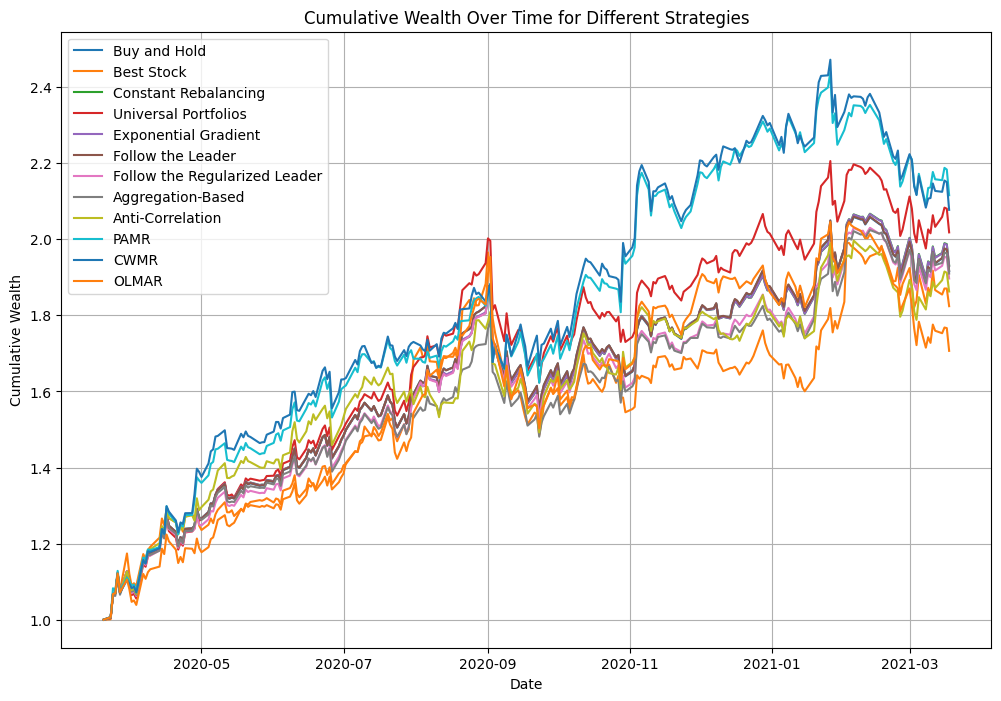

In [ ]:
import matplotlib.pyplot as plt
# Define a function to calculate cumulative wealth over time
def calculate_cumulative_wealth_over_time(b_n_1, price_relative_vectors, S0=1):
    """
    Calculate the cumulative wealth over time given a portfolio strategy.
    
    Parameters:
    b_n_1 : array-like
        A list of portfolio vectors for each period.
    price_relative_vectors : array-like
        A matrix of price relative vectors for each period.
    S0 : float, optional
        Initial wealth (default is 1).
    
    Returns:
    array-like : Cumulative wealth at each time period.
    """
    cumulative_wealth = np.zeros(len(price_relative_vectors))
    cumulative_wealth[0] = S0
    for t in range(len(price_relative_vectors)):
        if t == 0:
            period_return = calculate_period_return(b_n_1[t], price_relative_vectors[t])
            cumulative_wealth[t] = S0 * period_return
        else:
            period_return = calculate_period_return(b_n_1[t], price_relative_vectors[t])
            cumulative_wealth[t] = cumulative_wealth[t - 1] * period_return
    return cumulative_wealth

# Get the dates from the price_relative_vectors dataframe
dates = price_relative_vectors.index

# Dictionary to store cumulative wealth over time for each strategy
cumulative_wealth_dict = {}

# List of strategies to run
strategies = {
    'Buy and Hold': buy_and_hold,
    'Best Stock': best_stock,
    'Constant Rebalancing': constant_rebalancing,
    'Universal Portfolios': universal_portfolios,
    'Exponential Gradient': exponential_gradient,
    'Follow the Leader': follow_the_leader,
    'Follow the Regularized Leader': follow_the_regularized_leader,
    'Aggregation-Based': aggregation_based,
    'Anti-Correlation': anticor,
    'PAMR': pamr,
    'CWMR': cwmr,
    'OLMAR': olmar,
    'RMR': rmr
}

# Run each strategy and compute cumulative wealth over time
for strategy_name, strategy_function in strategies.items():
    try:
        print(f"Running strategy: {strategy_name}")
        b_n = strategy_function(b, price_relative_vectors_array)
        cumulative_wealth = calculate_cumulative_wealth_over_time(b_n, price_relative_vectors_array)
        cumulative_wealth_dict[strategy_name] = cumulative_wealth
    except Exception as e:
        print(f"Error running strategy {strategy_name}: {e}")

# Plot cumulative wealth over time
plt.figure(figsize=(12, 8))
for strategy_name, cumulative_wealth in cumulative_wealth_dict.items():
    plt.plot(dates, cumulative_wealth, label=strategy_name)  

plt.title('Cumulative Wealth Over Time for Different Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Wealth')
plt.legend()
plt.grid(True)
plt.show()

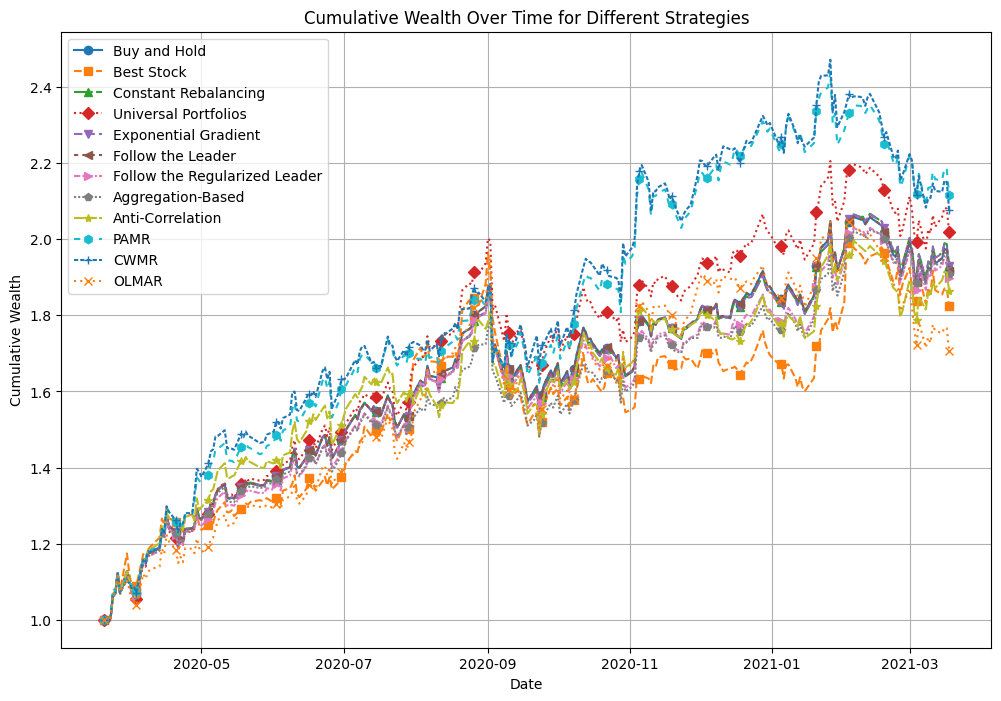

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Define a list of line styles
line_styles = [
    '-',        # Solid line
    '--',       # Dashed line
    '-.',       # Dash-dot line
    ':',        # Dotted line
    (0, (4, 2)),          # Dash pattern: 4pt dash, 2pt space
    (0, (2, 2)),          # Dash pattern: 2pt dash, 2pt space
    (0, (3, 1, 1, 1)),    # Dash-dot pattern with shorter spaces
    (0, (1, 1)),          # Dense dotted line
    (0, (5, 1)),          # Longer dash, short space
    (0, (3, 3)),          # Evenly spaced dashes
    (0, (2, 1)),          # Short dash, short space
    (0, (1, 2, 1, 2)),    # Dot-dash pattern
    (0, (1, 1, 1, 1)),    # Very dense dash-dot pattern
]

# Define a list of markers
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', '+', 'x', 'd']

# Ensure the lists are long enough
num_strategies = len(cumulative_wealth_dict)
if len(line_styles) < num_strategies:
    line_styles *= (num_strategies // len(line_styles) + 1)
if len(markers) < num_strategies:
    markers *= (num_strategies // len(markers) + 1)

# Plot cumulative wealth over time
plt.figure(figsize=(12, 8))

# Plot each strategy with line styles and markers
for i, (strategy_name, cumulative_wealth) in enumerate(cumulative_wealth_dict.items()):
    plt.plot(
        dates,
        cumulative_wealth,
        label=strategy_name,
        linestyle=line_styles[i],
        marker=markers[i],
        markevery=10,      # Adjust marker frequency as needed
        markersize=6,      # Adjust marker size as needed
        linewidth=1.5
    )  

plt.title('Cumulative Wealth Over Time for Different Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Wealth')
plt.legend()
plt.grid(True)
plt.show()
